# Homework 2. Classification of images.

In this task we need to train the image classifier. We will work with a dataset, the name of which we will not disclose. You can look for yourself at the pictures in the dataset. There are 200 classes and about 5 thousand pictures per class. The classes are numbered, as you can guess, from 0 to 199. You can download the dataset here [here](https://yadi.sk/d/BNR41Vu3y0c7qA).

The structure of dataset is simple - there are directories train/ and val/, where training and validation data are stored. In train/ and val/ lie the directories corresponding to the classes of images, where the images themselves lie.
 
__Assignment__.

1) Achieve an accuracy **on validation of at least 0.44**. In this task, it is **forbidden** to use preprocessed models and image resizing.

Write a brief report on your experiments. What worked and what didn't work? Why did you decide to do it this way and not that way? Be sure to provide references to other people's code if you use it. Be sure to cite articles / blogposts / questions on stackoverflow / videos from youtubers/machine operators / courses / tips from Uncle Vasya and other additional materials, if you use them.

Your code must necessarily pass all `asserts` below.

__Using external data for training is strictly forbidden in both tasks. It is also forbidden to train on a validation sample__.


__Grading Criteria__: The grade is calculated using a simple formula: `min(10, 10 * Your accuracy / 0.44)` for the first task and `min(10, 10 * (Your accuracy - 0.5) / 0.34)` for the second. The score is rounded to tenths according to arithmetic rules.
 
Good luck & have fun! :)

In [ ]:
%pip install wandb
%pip3 install pytorch_lightning torchmetrics

In [ ]:
%pip magic wandb

In [ ]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: livanovskaya. Use `wandb login --relogin` to force relogin


True

In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandomCrop

# You may add any imports you need

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

## Task 0

### Подготовка данных

In [ ]:
train_dataset = ImageFolder('dataset/dataset/train', transform=transforms.ToTensor())
val_dataset = ImageFolder('dataset/dataset/train', transform=transforms.ToTensor())

#normatization

means = []
std = []

for image, label in train_dataset:
    means.append(image.mean(dim=(1, 2)))
    std.append(image.std(dim=(1, 2)))


KeyboardInterrupt: 

In [ ]:
torch.stack(std).mean(dim=0)

In [ ]:
torch.stack(means).mean(dim=0)

In [ ]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
    ]
)
val_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
   
    ]
)

train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size = 128) 
val_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=False, batch_size = 128) 

In [ ]:
#!g1.4
 device = "cuda" if torch.cuda.is_available() else "cpu" 
 device

'cuda'

In [ ]:
#!g1.4
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Let's look at the pictures

torch.Size([3, 64, 64])


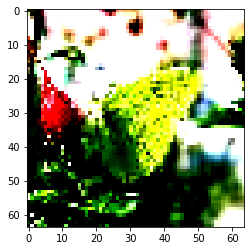

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


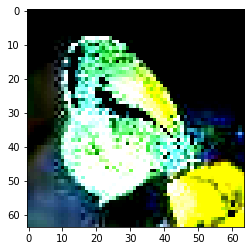

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    print(images[5].size()) #I added it to look at the size of the pictures for further work
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Task 1. 

Achieve a validation accuracy of at least 0.44. This task prohibits the use of pre-trained models and image resizing.

### Model

In [ ]:
#!g1.1
class YourNet(torch.nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        # YOUR CODE HERE
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 7),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride = 2), 
            torch.nn.Conv2d(64, 128, 3), 
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), 
        )
        self.lin_layers = torch.nn.Sequential(
            torch.nn.Linear(21632, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 200)
        )
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()


    def _forward(self, x):
        # runs the Neural Network
        # YOUR CODE HERE
        features = self.feature_extractor(x)
        flatten_features = torch.nn.Flatten()(features)
        return self.lin_layers(flatten_features)


    def forward(self, images, target=None):
        # YOUR CODE HERE
        output = self._forward(images)


        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss


    def get_accuracy(self, reset=False):
        # YOUR CODE HERE
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy


### Lightning training class

In [ ]:
#!g1.1
###
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda ep: 0.5, verbose=True)  

        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log("train_loss", loss, prog_bar=True)  
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        
        predict = self.model._forward(images)
        acur = accuracy(torch.argmax(predict, dim=-1).long(), target.long())
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acur, prog_bar=True)

In [ ]:
#!g1.1
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#!g1.1
wandb_logger = WandbLogger(log_model='all')
device = device 

LR = 0.0001

model = YourNet().to(device) 

module = YourModule(
    model,
    learning_rate=LR
    ) 

trainer = pl.Trainer(accelerator="gpu", max_epochs=20, devices = 1, logger = wandb_logger)


trainer.fit(module, train_dataloader, val_dataloader)

# trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)    
# trainer.tune(module, train_dataloader, val_dataloader)
# trainer.fit(module, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adjusting learning rate of group 0 to 1.0000e-04.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: livanovskaya. Use `wandb login --relogin` to force relogin



  | Name  | Type    | Params
----------------------------------
0 | model | YourNet | 11.3 M
----------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.369    Total estimated model params size (MB)


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
wandb.finish()

### Validation of job results

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=False)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
#report wandb (https://wandb.ai/livanovskaya/uncategorized/reports/-_2---VmlldzoyOTM1ODky?accessToken=3gyn3ywo9xjldf4kl039gxemrnc59tvsgcm3pv8y12wwwwcyd6s02qbyewmvody6)
model = model

accuracy = evaluate_task(model, val_dataloader)
print(f"The grade for this assignment will be {np.clip(10 * accuracy / 0.44, 0, 10):.2f} points")

# Experimental report

write the text here (or a link to wandb/any expression tracker) for each task

1: first I built the model as in the workshop, to debug that everything works. But my loss was nano and then I was fixing for a week to make it not work (changed optimizer, changed lerning rate, batting size, added clip grad and many other things that were advised on stackoverflow, but nothing helped.  
2: then i decided to import the resnet18 and train it on my data, but when i tried to connect it to the seminar lightning, it got an error (like many people on the course), so i tried to rewrite it via torch, but something didn't work there either and one assert didn't go through((  
3: eventually I was able to fix the lightning for my grid so I didn't have loss nan, and I started teaching it with optimizer Adam and the MultiplicativeLR shadooler.  
4: here's a report on my vandb models -
https://wandb.ai/livanovskaya/uncategorized/reports/-_2---VmlldzoyOTM1ODky?accessToken=3gyn3ywo9xjldf4kl039gxemrnc59tvsgcm3pv8y12wwwwcyd6s02qbyewmvody6